# Tooth and Cavity Instance Segmentation
Deep learning in dentistry holds a multitude of applications for identifying various dental conditions and diseases. Here, we train a deep-learning model for identifying and segmenting instances of the following:
- Caries
- Cavities
- Teeth
- Cracks

**Instance Segmentation** requires a model to not only create an image mask to classify objects pixel-by-pixel, but also to create boundaries to separate multiple instances of the same object. While multiple architectures are available for performing instance segmentation, we focus on training and comparing the following models:
- Mask RCNN
- YOLOv8

## Setup
Let's begin by importing necessary modules, set up some commonly used paths, and ingest our data. This data comes courtesy of Arab Academy on Roboflow:
- https://universe.roboflow.com/arab-academy-vf9su/dental-7yegp

In [1]:
import numpy as np
import cv2 as cv

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision
torchvision.disable_beta_transforms_warning()

from torchvision import models, datasets
from torchvision.datasets import (
    CocoDetection,
    wrap_dataset_for_transforms_v2
)
from torchvision.transforms import v2

from types import SimpleNamespace
from pathlib import Path
from pprint import pprint
from typing import Optional, Tuple
from collections import defaultdict
from tqdm.cli import tqdm

2024-08-10 01:42:14.370417: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-10 01:42:16.096481: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
%load_ext tensorboard

In [3]:
FPATHS = SimpleNamespace()
FPATHS.data = Path("../data/")

FPATHS.data_train = FPATHS.data / "train"
FPATHS.data_valid = FPATHS.data / "valid"
FPATHS.data_test = FPATHS.data / "test"

FPATHS.data_annotations_fname = "_annotations.coco.json"
FPATHS.data_train_annotations = FPATHS.data_train / FPATHS.data_annotations_fname
FPATHS.data_valid_annotations = FPATHS.data_valid / FPATHS.data_annotations_fname
FPATHS.data_test_annotations = FPATHS.data_test / FPATHS.data_annotations_fname

FPATHS.models = Path("../models/mask_rcnn/")
FPATHS.logs = Path("../logs/mask_rcnn")

In [4]:
MODEL_NAME = "maskrcnn_resnet50_fpn_v2"
MAX_EPOCHS = 50

# Memory constraints limits us to only 2 observations/batch (8GB VRAM)
BATCH_SIZE = 2

# For Testing purposes - only run these number of batches in training dataset
# MAX_BATCHES_TRAIN = np.inf
# MAX_BATCHES_VALID = np.inf
MAX_BATCHES_TRAIN = 16
MAX_BATCHES_VALID = MAX_BATCHES_TRAIN // 3

LEARNING_RATE = 1e-3
EARLY_STOP_PATIENCE = 5

# Learning rate schedule parameters (Reduce LR on Plateau)
LR_SCHEDULER_FACTOR = 0.1
LR_SCHEDULER_PATIENCE = 3

# How many batches to run through before logging our metrics
LOG_BATCH_INTERVAL = 16
LOG_VALID_IMAGES = BATCH_SIZE

assert LOG_VALID_IMAGES <= BATCH_SIZE and LOG_VALID_IMAGES >= 0, (
    "LOG_VALID_IMAGES must be non-negative and not larger than BATCH_SIZE"
)


print(f"""
Model Training 
- Model:                   {MODEL_NAME}
- Initial Learning Rate:   {LEARNING_RATE}
- Max Epochs:              {MAX_EPOCHS}
- Ealy Stop Patience:      {EARLY_STOP_PATIENCE}

Data Loading
- Batch Size:              {BATCH_SIZE}
- Maximum Batches (Train): {MAX_BATCHES_TRAIN}
- Maximum Batches (Valid): {MAX_BATCHES_VALID}

Logging
- Log Batch Interval:      {LOG_BATCH_INTERVAL} (Based on Effective Batch Size)
- Log Validation Images:   {LOG_VALID_IMAGES} (# Of Validation Images to Display)
""")


Model Training 
- Model:                   maskrcnn_resnet50_fpn_v2
- Initial Learning Rate:   0.001
- Max Epochs:              50
- Ealy Stop Patience:      5

Data Loading
- Batch Size:              2
- Maximum Batches (Train): 16
- Maximum Batches (Valid): 5

Logging
- Log Batch Interval:      16 (Based on Effective Batch Size)
- Log Validation Images:   2 (# Of Validation Images to Display)



### Defining Augmentations and Train/Val/Test Datasets
Since data provides bounding boxes, masks, and segmentations in the [COCO format](https://cocodataset.org/#home), we can utilize `torchvision.datasets.CocoDetection` class to help load the data in as a PyTorch Dataset.

We also define the augmentations to integrate with our training observations.

In [5]:
transforms_augment = v2.Compose([
    v2.ToImageTensor(),
    v2.RandomPhotometricDistort(p=0.5),
    v2.SanitizeBoundingBox(),
    v2.ConvertImageDtype()
])

transforms_process = v2.Compose([
    v2.ToImageTensor(),
    v2.SanitizeBoundingBox(),
    v2.ConvertImageDtype()
])

datasets = SimpleNamespace()
datasets.train = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
    transforms=transforms_augment
))

datasets.train_raw = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_train,
    FPATHS.data_train_annotations,
    transforms=transforms_process
    
))

datasets.valid = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_valid,
    FPATHS.data_valid_annotations,
    transforms=transforms_process
)),

# For some reason, the valid dataset is wrapped in a 1-element tuple
datasets.valid = datasets.valid[0]

datasets.test = wrap_dataset_for_transforms_v2(CocoDetection(
    FPATHS.data_test,
    FPATHS.data_test_annotations,
    transforms=transforms_process
))

category_id_to_name = {
    0: "Null",
    1: "Caries",
    2: "Cavity",
    3: "Crack",
    4: "Tooth"
}

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.32s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Visualizing Instances
Let's build out some functionality to visualize the bounding boxes, masks, and segmentations of each observation. We define `plot_coco_image()` for this purpose.

In [6]:
def plot_coco_image(
        image,
        target,
        plot_masks: bool = True,
        plot_bboxes: bool = True,
        plot_segmentations: bool = True,
        plot_category_id: bool = True,
        category_names: Optional[dict[int, str]] = None
    ):
    if image.shape[0] == 3:
        image = torch.moveaxis(image, 0, 2)
    bboxes = target["bbox"]
    masks = target["masks"]
    segmentations = target["segmentation"]
    categories = target["category_id"]

    fig, ax = plt.subplots(figsize=(6, 6), tight_layout=True)
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

    if plot_masks:
        for i, mask in enumerate(masks):
            ax.imshow(mask + 0.5 * i, alpha=mask * 0.25, cmap="tab10", vmin=0, vmax=len(masks) / 2)

    if plot_bboxes:
        for bbox in bboxes:
            x, y, width, height = bbox
            patch = matplotlib.patches.Rectangle(
                (x, y),
                width,
                height,
                alpha=1,
                fill=False,
                edgecolor="red",
                linewidth=1,
                mouseover=True
            )
            ax.add_patch(patch)

    if plot_segmentations:
        for segmentation in segmentations:
            x = [val for i, val in enumerate(segmentation[0]) if i % 2 == 0]
            y = [val for i, val in enumerate(segmentation[0]) if i % 2 != 0]
            ax.plot(x, y, color="black")

    if plot_category_id:
        for i, bbox in enumerate(bboxes):
            x, y, width, height = bbox
            category_id = categories[i]

            if category_names is not None:
                display_text = category_names[category_id]
            else:
                display_text = category_id
            
            ax.text(x+6, y-8, display_text, color="white", fontsize=6, backgroundcolor=(1, 0 ,0, 0.25))
        
        
    return fig
    

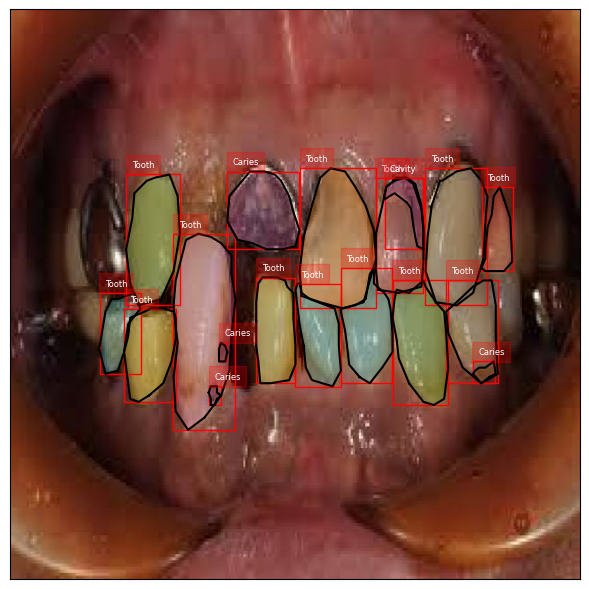

In [19]:
image, target = datasets.valid[6]
coco_image_example = plot_coco_image(
    image,
    target,
    plot_masks=True,
    plot_bboxes=True,
    plot_segmentations=True,
    plot_category_id=True,
    category_names=category_id_to_name,
)

### Creating a PyTorch `DataLoader`
Dataloader's help us retrieve a batch of training samples for more seamless model training training. Since PyTorch expects each batch to be constant, we have to update our `collate_fn`. We define `custom_collate_function()` to represent each batch as a tuple `(images, targets)`. To ensure we can run the network on our GPU, we also have to move the images and certain targets to the GPU.

Here, we can the structure of each batch:

```python
# Start iterating through the dataloader
images, targets = next(iter(dataloader))

# Extracts the first instance in the batch
image = images[0]
target = targets[0]

# Access the data in the target
target_bboxes = target["bbox"]
target_areas = target["area"]
target_segmentation = target["segmentation"]
```

In [9]:
def custom_collate_function(batch, to_cuda: bool = True):
    images, targets = tuple(zip(*batch))

    if not to_cuda:
        return (images, targets)

    images = torch.stack(images).cuda()
    for target in targets:
        pass
        target["boxes"] = target["boxes"].cuda()
        target["bbox"] = torch.Tensor(target["bbox"]).cuda()
        target["labels"] = torch.Tensor(target["labels"]).cuda()
        
    return (images, targets)


dataloaders = SimpleNamespace()
dataloaders.train = DataLoader(
    datasets.train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_function
)

dataloaders.valid = DataLoader(
    datasets.valid,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

dataloaders.test = DataLoader(
    datasets.test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_function
)

## Model - Mask RCNN

For instance segmentation, PyTorch provides [Mask R-CNN](https://pytorch.org/vision/0.9/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).


In [10]:
mask_rcnn = models.get_model(
    MODEL_NAME,
    weights=None,
    weights_backbone=None
)

mask_rcnn.cuda()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         

In [11]:
def process_output(output, spatial_size: Tuple[int, int]):
    # Move to CPU
    for key, val in output.items():
        if isinstance(val, torch.Tensor):
            output[key] = val.cpu()

    # Add in the "bbox" key
    bbox = torchvision.datapoints.BoundingBox(
        output["boxes"],
        format="XYXY",
        spatial_size=spatial_size
    )
    output["bbox"] = v2.ConvertBoundingBoxFormat("XYWH")(bbox)

    # We can remove the 2nd dimension of our masks.
    output["masks"] = output["masks"].squeeze(1)
    
    # Extract segmentation information from our masks
    output["segmentation"] = []
    for mask in output["masks"]:
        mask = np.ceil(np.array(mask)).astype(np.uint8)
        contours, hierarchy = cv.findContours(
            mask,
            mode=cv.RETR_EXTERNAL,
            method=cv.CHAIN_APPROX_NONE
        )
    
        segmentation = np.expand_dims(contours[-1].flatten(), 0)
        output["segmentation"].append(segmentation)

    # category_id is just a simple transformation of our labels
    output["category_id"] = [label.item() for label in output["labels"]]

    return output
    

def process_outputs(outputs, spatial_size: Tuple[int, int]):
    return [self.process_output(output, spatial_size) for output in outputs]

In [14]:
class MaskRCNNTrainer:
    def __init__(
            self,
            model,
            dataloader_train: DataLoader,
            dataloader_valid: DataLoader,
            learning_rate: float = 1e-3,
            scheduler_factor: float = 0.1,
            scheduler_patience: int = 3,
            early_stop_patience: int = 5,
            log_batches_interval: int = 16,
            fpath_logs: str = "logs",
            fpath_models: str = "models",
            max_batches_train: Optional[int] = None,
            max_batches_valid: Optional[int] = None
        ):
        """Custom trainer for PyTorch's Mask R-CNN Model. Implements the Adam
        optimizer, early stopping, and a learning rate scheduler
        (ReduceLROnPlateau). Utilizes Tensorboard to log batch and epoch
        losses, learning rates, and a subset of the validation outputs.
        """
        self.model = model

        # Dataloaders & properties
        self.dl_train = dataloader_train
        self.dl_valid = dataloader_valid
        
        self.dl_train_size = len(self.dl_train)
        self.dl_valid_size = len(self.dl_valid)

        # Determine batch size by peeking at the first iteration
        self.train_batch_size = len(next(iter(self.dl_train)))
        self.valid_batch_size = len(next(iter(self.dl_valid)))

        # Model optimizer and learning rate scheduling
        self.learning_rate = learning_rate
        self.optimizer = torch.optim.Adam(model.parameters(), learning_rate)
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode="min",
            factor=scheduler_factor,
            patience=scheduler_patience,
            verbose=True
        )

        # Early stopping
        self.early_stop_patience = early_stop_patience

        # File paths for tensorboard logs and model pickles
        self.fpath_logs = Path(fpath_logs)
        self.fpath_models = Path(fpath_models)

        # Allow a max batch size (Primarily for testing purposes)
        if max_batches_train is None:
            self.max_batches_train = np.inf
            self.final_size_train = self.dl_train_size
        else:
            self.max_batches_train = max_batches_train
            self.final_size_train = min(self.dl_train_size, max_batches_train)

        if max_batches_valid is None:
            self.max_batches_valid = np.inf
            self.final_size_valid = self.dl_valid_size
        else:
            self.max_batches_valid = max_batches_valid
            self.final_size_valid = min(self.dl_valid_size, max_batches_valid)

        # Traing loggings settings
        self.log_batches_interval = log_batches_interval

        # Store the state dict for our best and final model/optimizer/scheduler
        self.best_model_state_dicts = {
            "epoch": None,
            "valid_loss": None,
            "model_state_dict": None,
            "optimizer_state_dict": None,
            "scheduler_state_dict": None
        }

        self.final_model_state_dicts = {
            "epoch": None,
            "valid_loss": None,
            "model_state_dict": None,
            "optimizer_state_dict": None,
            "scheduler_state_dict": None
        }            

    def _train_loop(self, epoch: int, max_epochs: int, writer):
        epoch_loss = 0.0
        train_pbar = tqdm(
            enumerate(self.dl_train),
            total=self.final_size_train,
            desc=f"(Train) Epoch: {epoch + 1} / {max_epochs}"
        )

        self.model.train()
        for i, (images, targets) in train_pbar:
            # Forward pass
            loss_dict = self.model(images, targets)
            loss_dict["loss_overall"] = sum(loss for loss in loss_dict.values())

            # Backward pass
            self.optimizer.zero_grad()
            loss_dict["loss_overall"].backward()
            self.optimizer.step()

            # Track current epoch loss
            epoch_loss += loss_dict["loss_overall"].item()
            epoch_loss_avg = epoch_loss / (i + 1)
            train_pbar.set_postfix({"Avg Loss": f"{epoch_loss_avg:.4f}"})

            # Log Metrics
            if (i + 1) % self.log_batches_interval == 0 or (i + 1) == self.final_size_train:
                global_step = i + epoch * self.final_size_train
                writer.add_scalar("Loss/train_running", epoch_loss_avg, global_step)
                writer.add_scalar("Learning Rate", self.optimizer.param_groups[0]["lr"], global_step)

            # Leave if we are at the max batches
            if (i + 1) == self.final_size_train:
                break

        return epoch_loss_avg
            

    def _valid_loop(self, epoch: int, max_epochs: int, writer: Optional = None):
        epoch_loss = 0.0
        valid_pbar = tqdm(
            enumerate(self.dl_valid),
            total=self.final_size_valid,
            desc=f"(Valid) Epoch: {epoch + 1} / {max_epochs}"
        )

        # Even though were validating, we'll stay in train mode (To get loss)
        self.model.train()
        for i, (images, targets) in valid_pbar:
            # Forward pass
            loss_dict = self.model(images, targets)
            loss_dict["loss_overall"] = sum(loss for loss in loss_dict.values())

            # Track current epoch loss
            epoch_loss += loss_dict["loss_overall"].item()
            epoch_loss_avg = epoch_loss / (i + 1)
            valid_pbar.set_postfix({"Avg Loss": f"{epoch_loss_avg:.4f}"})
    
            # Leave if we are at the max batches
            if (i + 1) == self.final_size_valid:
                break

        return epoch_loss_avg
        
    def train(self, max_epochs: int):
        writer = SummaryWriter(self.fpath_logs)
        epochs_since_improvement = 0
        best_valid_loss = np.inf

        for epoch in range(max_epochs):
            # Train loop
            epoch_train_loss = self._train_loop(epoch, max_epochs, writer)
            writer.add_scalar("Loss/train_epoch", epoch_train_loss, epoch)

            # Validation loop
            with torch.no_grad():
                epoch_loss_valid = self._valid_loop(epoch, max_epochs)
                writer.add_scalar("Loss/valid_epoch", epoch_loss_valid, epoch)

            # Update the learning rate scheduler
            self.scheduler.step(epoch_loss_valid)

            # Model checkpointing & Early stop prep
            if epoch_loss_valid < best_valid_loss:
                best_valid_loss = epoch_loss_valid
                epochs_since_improvement = 0

                checkpoint_path = self.fpath_models / f"model_checkpoint_epoch_{epoch}.pth"
                self.best_model_state_dicts["epoch"] = epoch
                self.best_model_state_dicts["valid_loss"] = epoch_loss_valid
                self.best_model_state_dicts["model_state_dict"] = self.model.state_dict()
                self.best_model_state_dicts["optimizer_state_dict"] = self.optimizer.state_dict()
                self.best_model_state_dicts["scheduler_state_dict"] = self.scheduler.state_dict()
                torch.save(self.best_model_state_dicts, checkpoint_path)
            else:
                epochs_since_improvement += 1

            # Early stopping & Final model saving
            if epochs_since_improvement == self.early_stop_patience or (epoch + 1) == max_epochs:
                checkpoint_path = self.fpath_models / f"final_model_checkpoint_epoch_{epoch}.pth"
                self.final_model_state_dicts["epoch"] = epoch
                self.final_model_state_dicts["valid_loss"] = epoch_loss_valid
                self.final_model_state_dicts["model_state_dict"] = self.model.state_dict()
                self.final_model_state_dicts["optimizer_state_dict"] = self.optimizer.state_dict()
                self.final_model_state_dicts["scheduler_state_dict"] = self.scheduler.state_dict()
                torch.save(self.final_model_state_dicts, checkpoint_path)

                return None

In [ ]:
mask_rcnn_trainer = MaskRCNNTrainer(
    mask_rcnn,
    dataloaders.train,
    dataloaders.valid,
    learning_rate=LEARNING_RATE,
    scheduler_factor=LR_SCHEDULER_FACTOR,
    scheduler_patience=LR_SCHEDULER_PATIENCE,
    early_stop_patience=EARLY_STOP_PATIENCE,
    log_batches_interval=LOG_BATCH_INTERVAL,
    fpath_logs=FPATHS.logs,
    fpath_models=FPATHS.models,
    max_batches_train=MAX_BATCHES_TRAIN,
    max_batches_valid=MAX_BATCHES_VALID
)

mask_rcnn_trainer.train(MAX_EPOCHS)